In [34]:
#load libraries
library(ggplot2)
library(speedyseq)
library(microbiome)
library(phyloseq)
library(tidyverse)
library(dplyr)
library(vegan)
library(lubridate)
library(PCAtools)
library(GGally)
library(ggpmisc)
library(patchwork)
library(ggtext)
library(ggcorrplot)
library(ggplotify)
library(microViz)
library(qiime2R)
library(MicrobiomeStat)
library(pairwiseAdonis)
library(ggsignif)
library(ggpubr)

# Check package versions
packageVersion("phyloseq")
packageVersion("vegan")
packageVersion("pairwiseAdonis")


[1] ‘1.46.0’

[1] ‘2.6.8’

[1] ‘0.4.1’

In [2]:
#read metadata file and set factor order
meta = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/metadata/meta_EPA2.csv",
               header=TRUE, row.names=1)
meta$Site_Num <- as.integer(meta$Site_Num)
meta$Site.Status <- factor(meta$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))
head(meta, n=2)
dim(meta)


#read ASV table
ASV_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/merged_tables_BacArc_fill_EPA2.qza")
ASV_table <- ASV_qza$data
head(ASV_table, n=2)
dim(ASV_table)


#read taxa table
taxa_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/tax_EPA2.qza")
taxa_table <- taxa_qza$data
taxa_table <- taxa_qza$data %>%
as_tibble() %>% 
#select(-Confidence) %>% 
separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
arrange(Feature.ID) %>%
mutate(ASVs =paste('ASV',1:n(), sep = "_")) %>%
column_to_rownames("Feature.ID")%>%
as.matrix()

head(taxa_table, n=2)

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
518.H,518.H_S18,518.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
519.H,519.H_S18,519.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0


[1] 360  45

,R1.1.W,R1.10.W,R1.11.W,R1.12.W,R1.13.W,R1.14.W,R1.15.W,R1.16.W,R1.17.W,R1.18.W,⋯,GR.SINT.En4,GR.SINT.En5,GR.SINT.En6,TP.DLAB.En1,TP.DLAB.En2,TP.DLAB.En3,TP.DLAB.En4,TP.DLAB.En5,TP.DLAB.En6,TP.DSTO.En1
72caa013fe7649c65ffe72138ff7dfd1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2b248f10cca3c82a2640506132f9c869,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11756  1109

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 103262 rows [1, 2, 3, 7,
8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, ...].”


,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs
000003941bdff03b9dae68c9b7c5b7fc,d__Bacteria,p__Patescibacteria,c__Microgenomatia,o__Candidatus_Woesebacteria,f__Candidatus_Woesebacteria,g__Candidatus_Woesebacteria,NA,0.9713588,ASV_1
000009ca71fbef3a1702de6130f0b041,d__Bacteria,NA,NA,NA,NA,NA,NA,0.9965483,ASV_2


In [3]:
#create phyloseq object
ps = phyloseq(otu_table(ASV_table, taxa_are_rows=TRUE), 
               sample_data(meta),
tax_table(taxa_table))
ps %>% tax_fix()


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 360 samples ]:
sample_data() Sample Data:        [ 360 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

In [4]:
# Subset samples healthy and then by species
ps_AH <- subset_samples(ps, Sample.Type=="Healthy")

ps_ah_DSTO=subset_samples(ps_AH, Species_sample=="DSTO")
ps_ah_DSTO
ps_ah_SINT=subset_samples(ps_AH, Species_sample=="SINT")
ps_ah_SINT
ps_ah_MCAV=subset_samples(ps_AH, Species_sample=="MCAV")
ps_ah_MCAV
ps_ah_OFAV=subset_samples(ps_AH, Species_sample=="OFAV")
ps_ah_OFAV
ps_ah_PSTR=subset_samples(ps_AH, Species_sample=="PSTR")
ps_ah_PSTR

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 11756 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 11756 taxa by 9 taxonomic ranks ]:
taxa are rows

In [5]:
#filter coral species to remove ASVs in low prevelenace 
ps_fill_dsto = filter_taxa(ps_ah_DSTO, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_dsto
ps_fill_sint = filter_taxa(ps_ah_SINT, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_sint
ps_fill_mcav = filter_taxa(ps_ah_MCAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_mcav
ps_fill_ofav = filter_taxa(ps_ah_OFAV, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_ofav               
ps_fill_pstr = filter_taxa(ps_ah_PSTR, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_pstr                           

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1427 taxa and 16 samples ]:
sample_data() Sample Data:        [ 16 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 1427 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 2016 taxa and 17 samples ]:
sample_data() Sample Data:        [ 17 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 2016 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 535 taxa and 28 samples ]:
sample_data() Sample Data:        [ 28 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 535 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 805 taxa and 29 samples ]:
sample_data() Sample Data:        [ 29 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 805 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 1222 taxa and 27 samples ]:
sample_data() Sample Data:        [ 27 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 1222 taxa by 9 taxonomic ranks ]:
taxa are rows

In [6]:
#transform each to normalize data using center log ratio
ps_clr_dsto <- microbiome::transform(ps_fill_dsto, 'clr')
ps_clr_sint <- microbiome::transform(ps_fill_sint, 'clr')
ps_clr_mcav <- microbiome::transform(ps_fill_mcav, 'clr')
ps_clr_ofav <- microbiome::transform(ps_fill_ofav, 'clr')
ps_clr_pstr <- microbiome::transform(ps_fill_pstr, 'clr')

In [7]:
# ordinate each transformation for PCA
ps_clr_dst_ord <- ordinate(ps_clr_dsto, "RDA", "euclidean")
ps_clr_sint_ord <- ordinate(ps_clr_sint, "RDA", "euclidean")
ps_clr_mcav_ord <- ordinate(ps_clr_mcav, "RDA", "euclidean")
ps_clr_ofav_ord <- ordinate(ps_clr_ofav, "RDA", "euclidean")
ps_clr_pstr_ord <- ordinate(ps_clr_pstr, "RDA", "euclidean")

In [8]:
# merge the filtered and transformed species
ps_merge= merge_phyloseq(ps_clr_dsto,ps_clr_mcav, ps_clr_ofav, ps_clr_pstr, ps_clr_sint)

In [9]:
# merge the filtered and transformed species
ps_merge= merge_phyloseq(ps_fill_dsto,ps_fill_sint, ps_fill_mcav, ps_fill_ofav, ps_fill_pstr)

In [10]:
#transform to normalize data using center log ratio of merged corals
ps_merge_clr = microbiome::transform(ps_merge, 'clr')

## Figure 3

In [11]:
# select color palette 
cbPalette <- c( "#009E73","#D55E00","#696969")

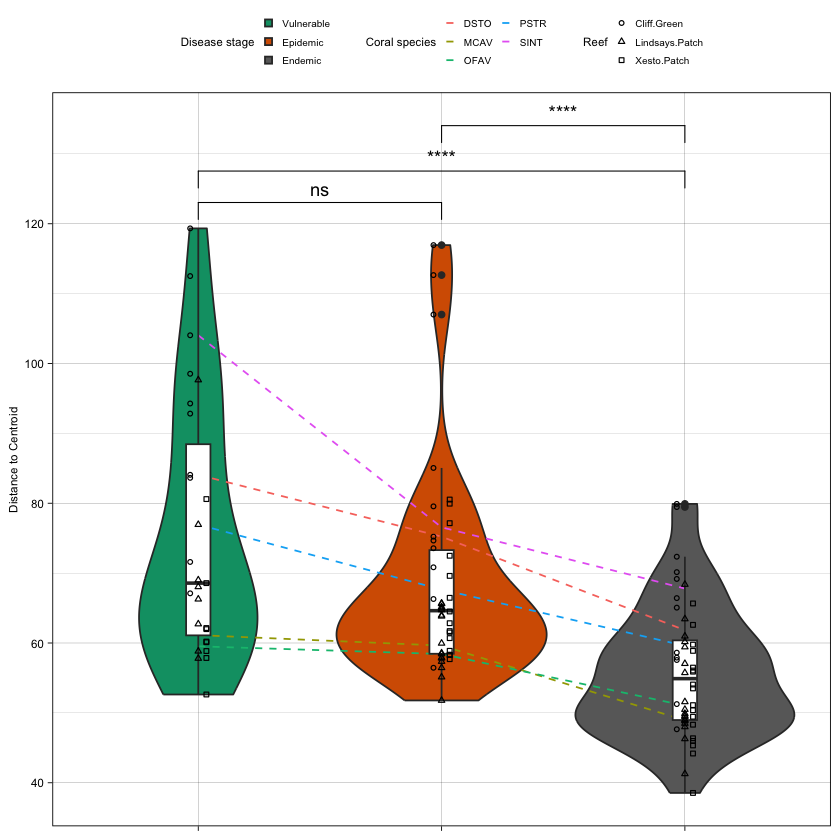

In [12]:
my_comparisons = list( c("Vulnerable", "Epidemic"), c("Vulnerable", "Endemic"), c("Endemic", "Epidemic") )

# Compute dissimilarity indices
dissimilarity_indices <- vegdist(otu_table(t(ps_merge_clr)), method = "euclidean")

# PERMDISP2 procedure for multivariate homogeneity of group dispersions
model <- betadisper(dissimilarity_indices, sample_data(ps_merge)$Site.Status)

# Convert distances to a data frame
distances_df <- as.data.frame(model$distances)

# Combine with sample data
combined_df <- cbind(sample_data(ps_merge), distances_df) 

# Set factor levels for Site.Status
combined_df$Site.Status <- factor(combined_df$Site.Status, 
                                   levels = c("Vulnerable", "Epidemic", "Endemic"))

# Create the dispersion plot
dispersion_plot <- ggplot(combined_df, aes(x = Site.Status, y = model$distances)) +
  geom_violin(aes(fill = Site.Status)) +
  stat_summary(
    fun = median,
    geom = 'line',
    linetype = "dashed",
    aes(group = Species_sample, color = Species_sample)
  ) +
  guides(group = guide_legend(order = 0),
         color = guide_legend(order = 1)) +
  geom_boxplot(width = 0.1) +
  geom_point(aes(shape = Site.Name), position = position_dodge(width = 0.1), size = 1) +
 scale_shape_manual(values = c(1,2,0)) +  # Assign different shapes
  scale_fill_manual(values = cbPalette) +
  theme_classic() +
  theme_linedraw() +
  ylab("Distance to Centroid") +
  theme(
    legend.text = element_text(size = 6),
    legend.title = element_text(size = 7),
    legend.key.height = unit(0.2, 'cm'),
    legend.key.width = unit(0.2, 'cm'),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 7),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 7),
  legend.position = "top") +
  guides(color = guide_legend(title = "Coral species", nrow=3),
         fill = guide_legend(title = "Disease stage", nrow=3),
         shape = guide_legend(title = "Reef", nrow=3)) +
  
 stat_compare_means(comparisons = my_comparisons, label.y = c(119, 123.5, 130
                                                             ), aes(label = after_stat(p.signif)))

dispersion_plot

In [13]:
#ordinate merged data
ps_merge_clr_ord <- ordinate(ps_merge_clr, "RDA", "euclidean")

In [14]:
ps_merge_meta= data.frame(sample_data(ps_merge))
head(ps_merge_meta)
dim(ps_merge_meta)
#ps_ra_ad
#distances between
ps_veg_ad = dist(otu_table(t(ps_merge_clr)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Season*Species_sample, 
       data =ps_merge_meta, 
         method = "euclidean", permutations = 999)



pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_merge)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")



,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A3,R3S7A3_S11,R3S7A3_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A4,R3S7A4_S11,R3S7A4_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A5,R3S7A5_S11,R3S7A5_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
CG.DSTO.En1,CG.DSTO.En1_S6,CG.DSTO.En1_S6,NA,Cliff.Green,Lower Keys,EPA2,Coral,DSTO,Healthy,Endemic,⋯,0,0,1,0,0,0,0,0,0,0


[1] 117  45

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,17,250300.8,0.4236729,4.281026,0.001
Residual,99,340487.0,0.5763271,NA,NA
Total,116,590787.8,1.0000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Endemic,1,32268.53,7.464421,0.09276673,0.001,0.003,*
Vulnerable vs Epidemic,1,39161.65,7.136195,0.09625791,0.001,0.003,*
Endemic vs Epidemic,1,34160.74,8.392287,0.08706389,0.001,0.003,*


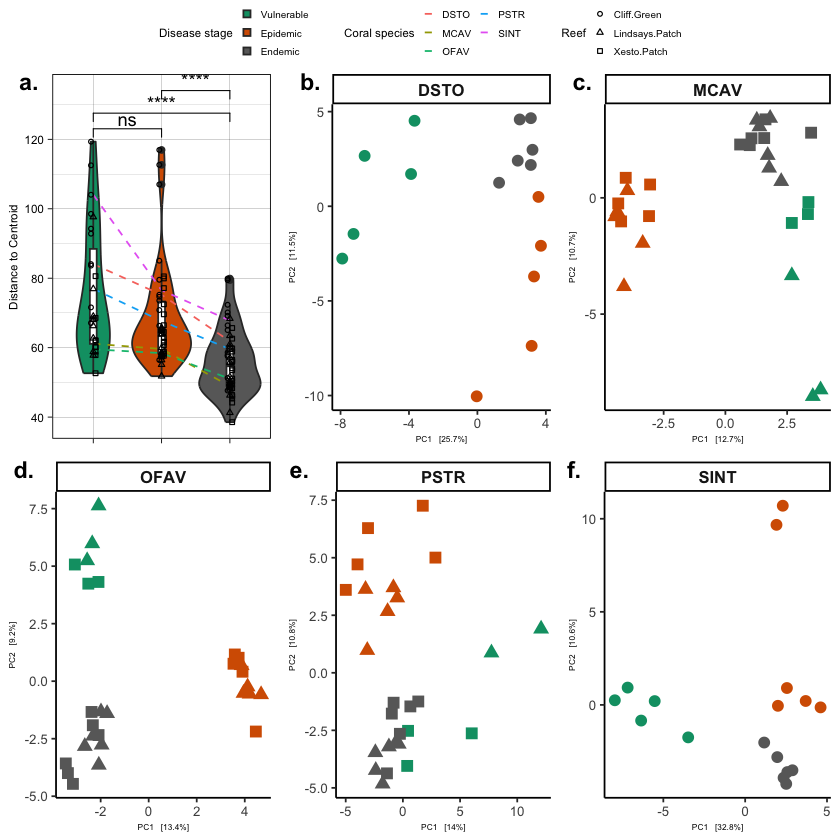

In [15]:

shape_mapping <- c("Cliff.Green" = 16, "Lindsays.Patch" = 17, "Xesto.Patch" = 15)

# List of datasets and corresponding labels
datasets <- list(
  list(data = ps_clr_dsto, ord = ps_clr_dst_ord),
  list(data = ps_clr_mcav, ord = ps_clr_mcav_ord),
  list(data = ps_clr_ofav, ord = ps_clr_ofav_ord),
   list(data = ps_clr_pstr, ord = ps_clr_pstr_ord),
  list(data = ps_clr_sint, ord = ps_clr_sint_ord)


)

# Create a list to store plots
plots <- list()

# Loop through each dataset
for (i in seq_along(datasets)) {
  # Extracting dataset, ordination data, and label
  data <- datasets[[i]]$data
  ord <- datasets[[i]]$ord
  
  # Plotting ordination
  p <- plot_ordination(
    data, ord,
      #label="Site.Name",
    color = "Site.Status",
    axes = c(1, 2), shape="Site.Name"
  ) +

    geom_point(size = 3) +
    scale_color_manual(values = cbPalette) +
     scale_shape_manual(values = shape_mapping) +
    theme_classic() +
    facet_wrap(Species_sample~.) +
     theme(strip.text = element_text(
    size = 10, face="bold")) +
    theme(legend.text = element_text(size = 6)) +
    theme(legend.title = element_text(size = 6)) +
    theme(axis.title.x = element_text(size = 5)) +
    theme(axis.title.y = element_text(size = 5)) +
    theme(axis.text.x = element_text(size = 8)) +
    theme(axis.text.y = element_text(size = 8)) +
    #stat_ellipse() +
    guides(color = guide_legend(title = "Disease stage"),
        fill = "none", linetype = "none", shape = "none",
          )
  
  # Add plot to the list
  plots[[i]] <- p
}

# Arrange plots using ggarrange
combined_plots <- ggarrange(dispersion_plot, plotlist =plots, nrow = 2, ncol=3, common.legend = TRUE,
                           labels = c(" a.", " b.", "c. ", "d. ", "e.", "f."))

# Print the combined plot
print(combined_plots)


ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Figure3.png",
     width = 6, height = 7.5, units = "in", dpi=300)

## PERMANOVA of each coral 

## DSTO 

In [16]:
ps_clr_dst_meta= data.frame(sample_data(ps_clr_dsto))
head(ps_clr_dst_meta, n=2)
dim(ps_clr_dst_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_dsto)), method ="euclidean")


adonis2(ps_veg_ad~Site.Status*Season,
       data =ps_clr_dst_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_dsto)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")


,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7A1,R3S7A1_S11,R3S7A1_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
R3S7A2,R3S7A2_S11,R3S7A2_S11,NA,Cliff.Green,Lower Keys,EPA1,Coral,DSTO,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0


[1] 16 45

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,2,25939.78,0.3369085,3.302569,0.001
Residual,13,51053.76,0.6630915,NA,NA
Total,15,76993.55,1.0000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Endemic,1,15778.139,4.367077,0.3267039,0.003,0.009,*
Vulnerable vs Epidemic,1,15872.074,3.590954,0.3098066,0.005,0.015,.
Endemic vs Epidemic,1,7523.294,1.978043,0.1801817,0.001,0.003,*


## OFAV

In [17]:
ps_clr_ofav_meta= data.frame(sample_data(ps_clr_ofav))
head(ps_clr_ofav_meta, n=2)
dim(ps_clr_ofav_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_ofav)), method ="euclidean")

adonis2(ps_veg_ad~Site.Status*Season,
       data =ps_clr_ofav_meta, 
         method = "euclidean", permutations = 999)

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_ofav)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")


,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
518.H,518.H_S18,518.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
519.H,519.H_S18,519.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0


[1] 29 45

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,22785.21,0.268632,3.06084,0.001
Residual,25,62034.20,0.731368,NA,NA
Total,28,84819.41,1.000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,9566.823,3.468819,0.1878203,0.001,0.003,*
Vulnerable vs Endemic,1,7305.515,3.162647,0.1650423,0.001,0.003,*
Epidemic vs Endemic,1,10557.076,4.084374,0.1628254,0.001,0.003,*


## MCAV

In [18]:
ps_clr_mcav_meta= data.frame(sample_data(ps_clr_mcav))
head(ps_clr_mcav_meta, n=2)
dim(ps_clr_mcav_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_mcav)), method ="euclidean")

adonis2(ps_veg_ad~Site.Status*Season,
       data =ps_clr_mcav_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_mcav)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")


,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
521.H,521.H_S18,521.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,MCAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
522.H,522.H_S18,522.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,MCAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0


[1] 28 45

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,18012.87,0.2736868,3.014532,0.001
Residual,24,47802.75,0.7263132,NA,NA
Total,27,65815.62,1.0000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,7505.778,3.070525,0.1798729,0.001,0.003,*
Vulnerable vs Endemic,1,5862.556,3.109849,0.1627354,0.001,0.003,*
Epidemic vs Endemic,1,7487.741,3.804340,0.1598171,0.001,0.003,*


## SINT

In [19]:
ps_clr_sint_meta= data.frame(sample_data(ps_clr_sint))
head(ps_clr_sint_meta, n=2)
dim(ps_clr_sint_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_sint)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Season,
       data =ps_clr_sint_meta, 
         method = "euclidean", permutations = 999)

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_sint)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")


,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3S7C1,R3S7C1_S12,R3S7C1_S12,NA,Cliff.Green,Lower Keys,EPA1,Coral,SINT,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
R3S7C2,R3S7C2_S12,R3S7C2_S12,NA,Cliff.Green,Lower Keys,EPA1,Coral,SINT,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0


[1] 17 45

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,2,31378.38,0.3880922,4.439633,0.001
Residual,14,49474.52,0.6119078,NA,NA
Total,16,80852.90,1.0000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Endemic,1,19554.405,5.901804,0.3960463,0.005,0.015,.
Vulnerable vs Epidemic,1,21878.509,5.374269,0.3738812,0.004,0.012,.
Endemic vs Epidemic,1,6472.537,1.992124,0.1661194,0.003,0.009,*


## PSTR

In [20]:
ps_clr_pstr_meta= data.frame(sample_data(ps_clr_pstr))
head(ps_clr_pstr_meta, n=2)
dim(ps_clr_pstr_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_pstr)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Site.Status*Season,
       data =ps_clr_pstr_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_pstr)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
527.H,527.H_S18,527.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,PSTR,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
528.H,528.H_S18,528.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,PSTR,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0


[1] 27 45

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,33090.73,0.2713448,2.854999,0.001
Residual,23,88860.13,0.7286552,NA,NA
Total,26,121950.86,1.0000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,13200.21,2.787774,0.1765780,0.001,0.003,*
Vulnerable vs Endemic,1,10924.00,2.840185,0.1592016,0.001,0.003,*
Epidemic vs Endemic,1,11757.36,3.051101,0.1323625,0.001,0.003,*


## Sediment and water samples dispersion

In [21]:
# Subset samples for Sediment type
ps_Sediment <- subset_samples(ps, subset = sample_data(ps)$Type == "Sediment")

ps_fill_s = filter_taxa(ps_Sediment, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_s

ps_Water <- subset_samples(ps, subset = sample_data(ps)$Type == "Water")

ps_fill_w = filter_taxa(ps_Water, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_w

ps_clr_s <- microbiome::transform(ps_fill_s, 'clr')
psr_clr_ord_s <- ordinate(ps_clr_s, "RDA", "euclidean")


ps_clr_w <- microbiome::transform(ps_fill_w, 'clr')
psr_clr_ord_w <- ordinate(ps_clr_w, "RDA", "euclidean")


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 4389 taxa and 90 samples ]:
sample_data() Sample Data:        [ 90 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 4389 taxa by 9 taxonomic ranks ]:
taxa are rows

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 940 taxa and 96 samples ]:
sample_data() Sample Data:        [ 96 samples by 45 sample variables ]:
tax_table()   Taxonomy Table:     [ 940 taxa by 9 taxonomic ranks ]:
taxa are rows

## Sediment dispersion

In [22]:
# compute dissimilarity indices
dis_s <- vegdist(otu_table(t(ps_clr_s)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod<- betadisper(dis_s, sample_data(ps_clr_s)$Site.Status)
mod
tukey_test <- TukeyHSD(mod, pairwise = TRUE)
tukey_test
mod_dist_s=as.data.frame(mod$distances)
dim(mod_dist_s)
mod_dist_df_s=cbind(sample_data(ps_clr_s), mod_dist_s) 
head(mod_dist_df_s)


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis_s, group = sample_data(ps_clr_s)$Site.Status)

No. of Positive Eigenvalues: 89
No. of Negative Eigenvalues: 0

Average distance to median:
Vulnerable   Epidemic    Endemic 
     89.34     110.97     111.04 

Eigenvalues for PCoA axes:
(Showing 8 of 89 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
166288 107797  45291  38744  26877  22627  19949  17072 

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                           diff       lwr       upr     p adj
Epidemic-Vulnerable 21.62772858 16.439087 26.816370 0.0000000
Endemic-Vulnerable  21.70298585 16.514344 26.891627 0.0000000
Endemic-Epidemic     0.07525727 -5.113384  5.263899 0.9993408


[1] 90  1

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat,mod$distances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
R3.1.S,R3.1.S_S13,R3.1.S_S13,NA,Cliff.Green,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,0,0,0,1,0,0,0,0,0,92.61484
R3.10.S,R3.10.S_S13,R3.10.S_S13,NA,Cliff.Green,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,0,0,0,1,0,0,0,0,0,93.94526
R3.11.S,R3.11.S_S13,R3.11.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,0,0,0,1,0,0,0,0,0,87.79212
R3.12.S,R3.12.S_S13,R3.12.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,0,0,0,1,0,0,0,0,0,86.61877
R3.13.S,R3.13.S_S13,R3.13.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,0,0,0,1,0,0,0,0,0,89.23114
R3.14.S,R3.14.S_S13,R3.14.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,0,0,0,1,0,0,0,0,0,93.05484


## Water dispersion

In [23]:
# compute dissimilarity indices
dis_w <- vegdist(otu_table(t(ps_clr_w)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod<- betadisper(dis_w, sample_data(ps_clr_w)$Site.Status)
mod
tukey_test <- TukeyHSD(mod, pairwise = TRUE)
tukey_test
mod_dist_w=as.data.frame(mod$distances)
dim(mod_dist_w)
mod_dist_df_w=cbind(sample_data(ps_clr_w), mod_dist_w) 
head(mod_dist_df_w)


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis_w, group = sample_data(ps_clr_w)$Site.Status)

No. of Positive Eigenvalues: 95
No. of Negative Eigenvalues: 0

Average distance to median:
Vulnerable   Epidemic    Endemic 
     30.81      39.88      42.62 

Eigenvalues for PCoA axes:
(Showing 8 of 95 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
97770 28427 23827 10452  6850  4876  3714  3280 

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                         diff       lwr       upr     p adj
Epidemic-Vulnerable  9.069050  2.985111 15.152988 0.0017389
Endemic-Vulnerable  11.810855  5.726917 17.894794 0.0000359
Endemic-Epidemic     2.741805 -3.612661  9.096272 0.5613564


[1] 96  1

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat,mod$distances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
R3.1.W,R3.1.W_S14,R3.1.W_S14,NA,Cliff.Green,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,38.70039
R3.10.W,R3.10.W_S14,R3.10.W_S14,NA,Cliff.Green,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,23.62754
R3.11.W,R3.11.W_S14,R3.11.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,23.13442
R3.12.W,R3.12.W_S14,R3.12.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,20.16302
R3.13.W,R3.13.W_S14,R3.13.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,22.74236
R3.14.W,R3.14.W_S14,R3.14.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,21.75199


## Figure 4

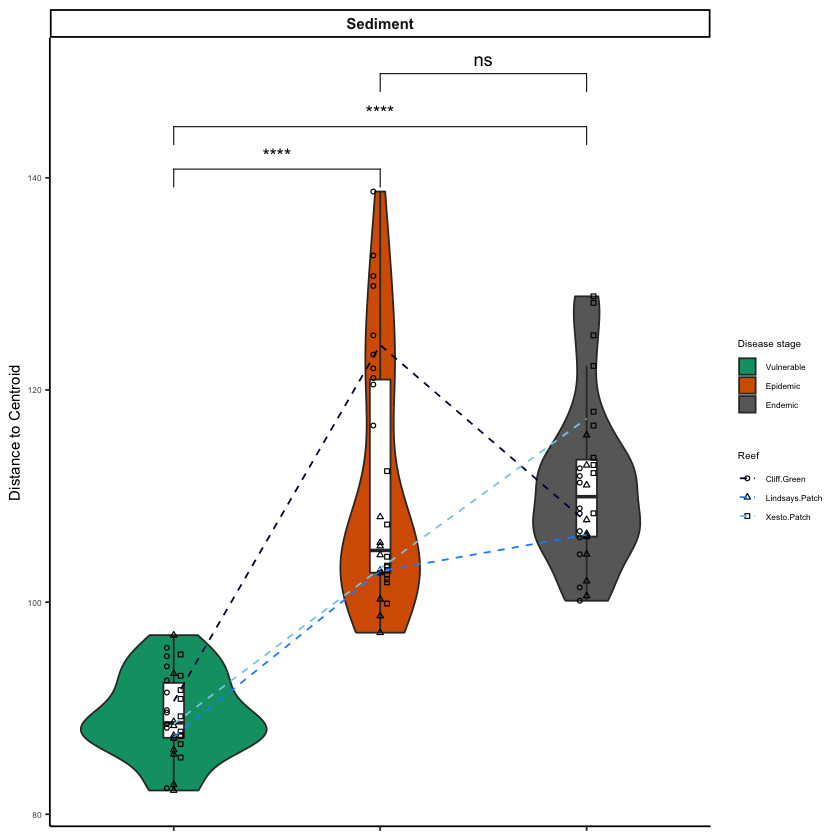

In [24]:
# Compute Euclidean distance matrix
dis_s <- vegdist(otu_table(t(ps_clr_s)), method = "euclidean")

# PERMDISP2: Analysis of multivariate homogeneity of group dispersions
mod_s <- betadisper(dis_s, sample_data(ps_clr_s)$Site.Status)
mod_dist_s <- as.data.frame(mod_s$distances)

# Combine with sample metadata
mod_dist_df_s <- cbind(sample_data(ps_clr_s), mod_dist_s)

# Create violin and box plot visualization
disp_fig_s <- ggplot(mod_dist_df_s, aes(x = Site.Status, y = mod_s$distances)) +
  geom_violin(aes(fill = Site.Status)) +
  geom_boxplot(width = 0.1, outlier.shape = NA) +
  geom_point(aes(shape = Site.Name), position = position_dodge(width = 0.1), size = 1) +
 scale_shape_manual(values = c(1,2,0)) +  # Assign different shapes
  stat_summary(
    fun = median,
    geom = "line",
    linetype = "dashed",
    aes(group = Site.Name, color = Site.Name)
  ) +
  scale_color_manual(values = c("#000042", "#1E90FF", "#87CEEB")) +
  scale_fill_manual(values = cbPalette) +
  facet_grid(. ~ Type) +
  theme_classic() +
  ylab("Distance to Centroid") +
  theme(
    strip.text = element_text(size = 9, face = "bold"),
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 6),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 9),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 5),
    legend.key.size = unit(0.4, "cm")  # Combines height & width
  ) +
  guides(
    color = guide_legend(title = "Reef"),
    shape = guide_legend(title = "Reef"),
    fill = guide_legend(title = "Disease stage", order = 0)
  ) +
  stat_compare_means(
    comparisons = my_comparisons,
    label.y = c(138, 142, 147),
    aes(label = after_stat(p.signif))
  )

disp_fig_s




	Homogeneity of multivariate dispersions

Call: betadisper(d = dis, group = sample_data(ps_clr_w)$Site.Status)

No. of Positive Eigenvalues: 95
No. of Negative Eigenvalues: 0

Average distance to median:
Vulnerable   Epidemic    Endemic 
     30.81      39.88      42.62 

Eigenvalues for PCoA axes:
(Showing 8 of 95 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
97770 28427 23827 10452  6850  4876  3714  3280 

[1] 96  1

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat,mod$distances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
R3.1.W,R3.1.W_S14,R3.1.W_S14,NA,Cliff.Green,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,38.70039
R3.10.W,R3.10.W_S14,R3.10.W_S14,NA,Cliff.Green,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,23.62754
R3.11.W,R3.11.W_S14,R3.11.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,23.13442
R3.12.W,R3.12.W_S14,R3.12.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,20.16302
R3.13.W,R3.13.W_S14,R3.13.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,22.74236
R3.14.W,R3.14.W_S14,R3.14.W_S14,Site-G,Xesto.Patch,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,0,0,0,0,0,0,1,0,0,21.75199


Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“Duplicated aesthetics after name standardisation: fill”


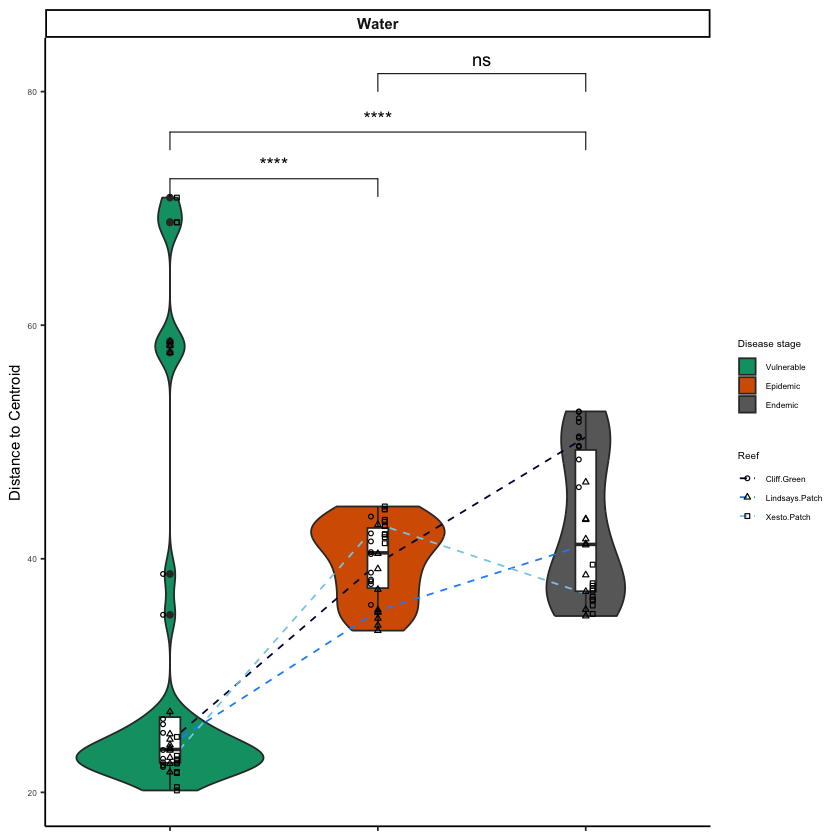

In [25]:
dis <- vegdist(otu_table(t(ps_clr_w)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod<- betadisper(dis, sample_data(ps_clr_w)$Site.Status)
mod
mod_dist= as.data.frame(mod$distances)
dim(mod_dist)
mod_dist_df_w=cbind(sample_data(ps_clr_w), mod_dist) 
head(mod_dist_df_w)


disp_fig_w=ggplot(mod_dist_df_w,
       aes(x=Site.Status, y=mod$distances)) +
  geom_violin(aes(fill = Site.Status)) +
  stat_summary(
    fun.y = median,
    geom = 'line',
    linetype = "dashed",
    aes(group = Site.Name, color = Site.Name)
  ) +
  geom_boxplot(width = 0.1) +
   geom_point(aes(shape = Site.Name), position = position_dodge(width = 0.1), size = 1) +
 scale_shape_manual(values = c(1,2,0)) +  # Assign different shapes
  scale_color_manual(values = c("#000042", "#1E90FF", "#87CEEB")) +
  scale_fill_manual(values = cbPalette) +
  facet_grid(. ~ Type) +
  theme_classic() +
  ylab("Distance to Centroid") +
  theme(
    strip.text = element_text(size = 9, face = "bold"),
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 6),
    axis.title.x = element_blank(),
    axis.title.y = element_text(size = 9),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 5),
    legend.key.height = unit(0.4, 'cm'),
    legend.key.width = unit(0.4, 'cm')
  ) +
  guides(
    color= guide_legend(title = "Reef"),
    shape = guide_legend(title = "Reef"),
    fill = guide_legend(title = "Disease stage"),
    group = guide_legend(order = 1),
    fill = guide_legend(order = 0)
  ) +
 stat_compare_means(comparisons = my_comparisons, label.y = c(70, 74, 79
                                                             ), aes(label = after_stat(p.signif)))
disp_fig_w

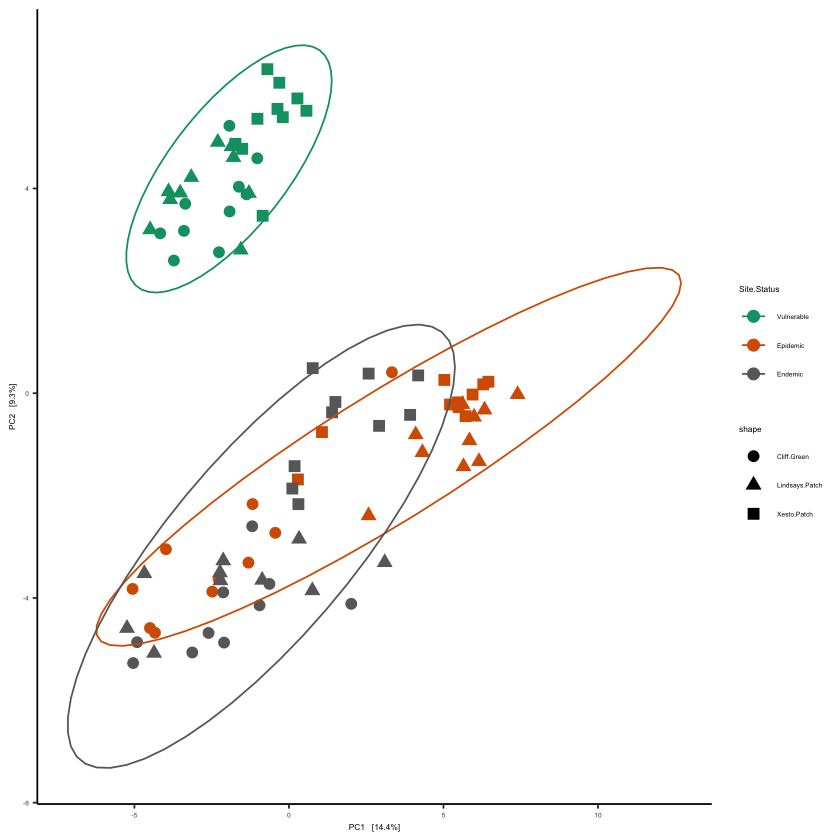

In [26]:
ord_s= plot_ordination(ps_clr_s,
    psr_clr_ord_s,
    color = "Site.Status",
    axes = c(1, 2)
  ) +

    geom_point(size = 3, aes(shape=Site.Name)) +
    scale_color_manual(values = cbPalette) +
    theme_classic() +
    #facet_wrap(. ~ Species_sample) +
    theme(legend.text = element_text(size = 4)) +
    theme(legend.title = element_text(size = 5)) +
    theme(axis.title.x = element_text(size = 5)) +
    theme(axis.title.y = element_text(size = 5)) +
    theme(axis.text.x = element_text(size = 4)) +
    theme(axis.text.y = element_text(size = 4)) +
    stat_ellipse() #+
    #guides(fill = "none", color = "none", linetype = "none", shape = "none")
ord_s

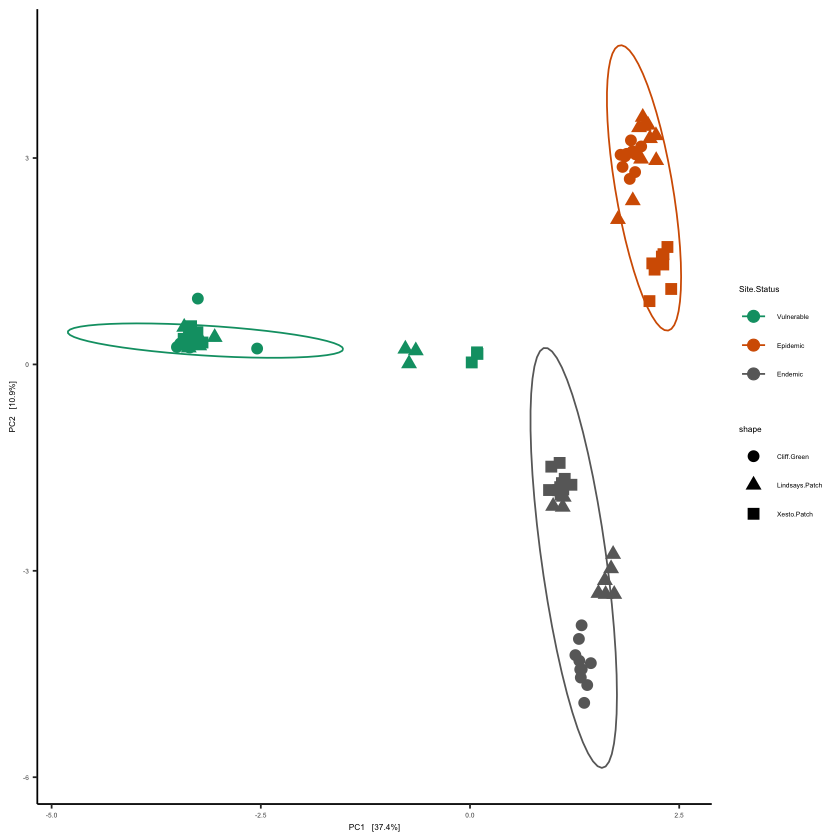

In [27]:
ord_w = plot_ordination(ps_clr_w,
    psr_clr_ord_w,
    color = "Site.Status",
    axes = c(1, 2)
  ) +

    geom_point(size = 3, aes(shape=Site.Name)) +
    scale_color_manual(values = cbPalette) +
    theme_classic() +
    #facet_wrap(. ~ Species_sample) +
    theme(legend.text = element_text(size = 4)) +
    theme(legend.title = element_text(size = 5)) +
    theme(axis.title.x = element_text(size = 5)) +
    theme(axis.title.y = element_text(size = 5)) +
    theme(axis.text.x = element_text(size = 4)) +
    theme(axis.text.y = element_text(size = 4)) +
    stat_ellipse() #+
    #guides(fill = "none", color = "none", linetype = "none", shape = "none")
ord_w

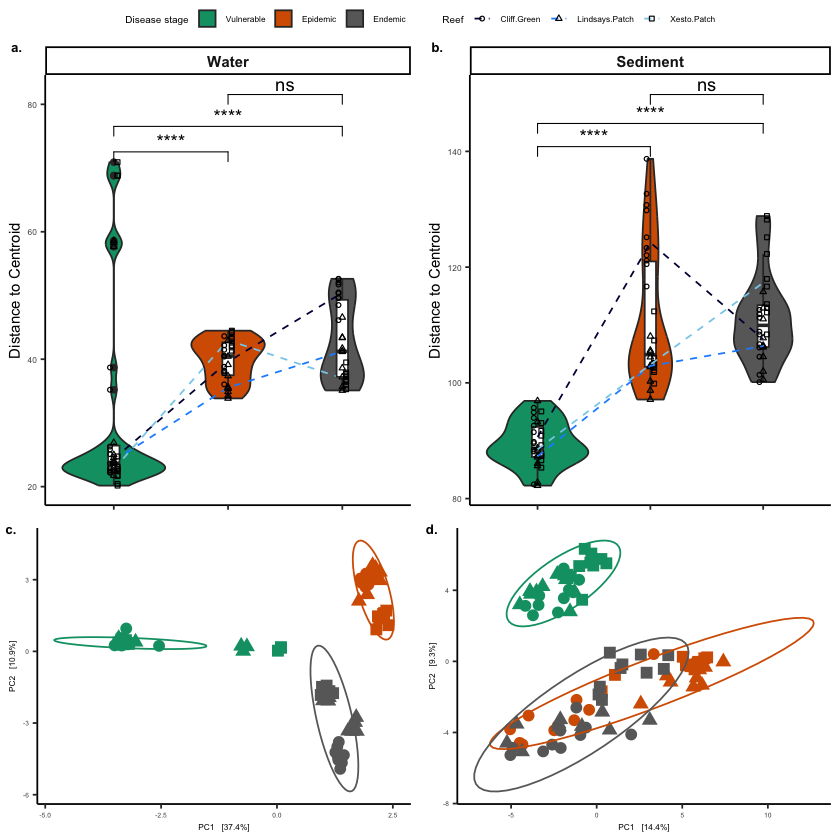

In [28]:
ggarrange(disp_fig_w, disp_fig_s, ord_w, ord_s, nrow = 2, ncol=2, common.legend = TRUE, heights=c(1.5,1),
                           labels = c(" a.", " b.", "c.", "d."),
         
         font.label = list(size = 8, color = "black"))

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Figure4.png",
    width = 5, height = 6, units = "in", dpi=300)

## PERMANOVA sediment and water

In [29]:
ps_clr_s_meta= data.frame(sample_data(ps_clr_s))
head(ps_clr_s_meta, n=2)
dim(ps_clr_s_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_s)), method ="euclidean")

adonis2(ps_veg_ad~Site.Status*Season,
       data =ps_clr_s_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_s)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")


,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3.1.S,R3.1.S_S13,R3.1.S_S13,NA,Cliff.Green,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.10.S,R3.10.S_S13,R3.10.S_S13,NA,Cliff.Green,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0


[1] 90 45

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,2,170910.1,0.147968,7.55442,0.001
Residual,87,984137.7,0.852032,NA,NA
Total,89,1155047.8,1.000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,106701.40,10.101532,0.14833046,0.001,0.003,*
Vulnerable vs Endemic,1,90889.86,8.622596,0.12942449,0.001,0.003,*
Epidemic vs Endemic,1,58773.89,4.580260,0.07319018,0.001,0.003,*


In [30]:
ps_clr_w_meta= data.frame(sample_data(ps_clr_w))
head(ps_clr_w_meta, n=2)
dim(ps_clr_w_meta)
#distances between
ps_veg_ad = dist(otu_table(t(ps_clr_w)), method ="euclidean")

adonis2(ps_veg_ad~Site.Status*Season,
       data =ps_clr_w_meta, 
         method = "euclidean", permutations = 999)


pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_clr_w)$Site.Status, sim.method = "euclidean",
                p.adjust.m = "bonferroni")


,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3.1.W,R3.1.W_S14,R3.1.W_S14,NA,Cliff.Green,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,2,0,0,0,0,0,0,1,0,0
R3.10.W,R3.10.W_S14,R3.10.W_S14,NA,Cliff.Green,Lower Keys,EPA1,Water,Water,NA,Vulnerable,⋯,2,0,0,0,0,0,0,1,0,0


[1] 96 45

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,128526.8,0.4918534,29.68337,0.001
Residual,92,132784.4,0.5081466,NA,NA
Total,95,261311.2,1.0000000,NA,NA


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Vulnerable vs Epidemic,1,80042.64,57.32746,0.4725019,0.001,0.003,*
Vulnerable vs Endemic,1,63595.48,42.11177,0.3968624,0.001,0.003,*
Epidemic vs Endemic,1,28659.13,16.09336,0.2172038,0.001,0.003,*


In [31]:
data_combined <- data.frame(
  Variable = c("Disease stage", "Season", "Project", "Reef", "Date", 
               "Disease stage:Season",
               "Disease stage", "Reef", "Date", "Disease stage:Reef",
               "Disease stage", "Season", "Coral Species", "Project", "Reef", 
               "Date", "Disease stage:Coral Species", "Season:Coral Species", 
               "Coral Species:Reef", "Coral Species:Date"),
  Df = c(2, 1, 1, 2, 2, 
         3, 
         2, 2, 2, 3, 
         2, 1, 4, 1, 1, 
         3, 6, 2, 
         2, 2),
  SumOfSqs = c(116663, 11864, 9236, 7726, 17762, 
               11612, 
               170910, 90827, 33445, 69889, 
               70058, 22363, 80917, 16417, 6085, 
               19033, 41517, 8250, 
               8703, 8311),
  R2 = c(0.44645, 0.04540, 0.03534, 0.02957, 0.06797, 
         0.04444, 
         0.14797, 0.07863, 0.02896, 0.06051, 
         0.11858, 0.03785, 0.13696, 0.02779, 0.01030, 
         0.03222, 0.07027, 0.01396, 
         0.01473, 0.01407),
  F = c(56.679, 11.528, 8.974, 3.754, 8.629, 
        3.761, 
        8.6539, 4.5989, 1.6935, 2.3592, 
        10.4248, 6.6552, 6.0203, 4.8857, 1.8110, 
        1.8881, 2.0593, 1.2276, 
        1.2951, 1.2367),
  Pvalue = c(0.001, 0.001, 0.001, 0.001, 0.001, 
             0.001, 
             0.001, 0.001, 0.009, 0.001, 
             0.001, 0.001, 0.001, 0.001, 0.009, 
             0.004, 0.001, 0.125, 
             0.046, 0.084),
  Type = c(rep("Water", 6), rep("Sediment", 4), rep("Coral", 10))
)

print(data_combined)


                      Variable Df SumOfSqs      R2       F Pvalue     Type
1                Disease stage  2   116663 0.44645 56.6790  0.001    Water
2                       Season  1    11864 0.04540 11.5280  0.001    Water
3                      Project  1     9236 0.03534  8.9740  0.001    Water
4                         Reef  2     7726 0.02957  3.7540  0.001    Water
5                         Date  2    17762 0.06797  8.6290  0.001    Water
6         Disease stage:Season  3    11612 0.04444  3.7610  0.001    Water
7                Disease stage  2   170910 0.14797  8.6539  0.001 Sediment
8                         Reef  2    90827 0.07863  4.5989  0.001 Sediment
9                         Date  2    33445 0.02896  1.6935  0.009 Sediment
10          Disease stage:Reef  3    69889 0.06051  2.3592  0.001 Sediment
11               Disease stage  2    70058 0.11858 10.4248  0.001    Coral
12                      Season  1    22363 0.03785  6.6552  0.001    Coral
13               Coral Sp

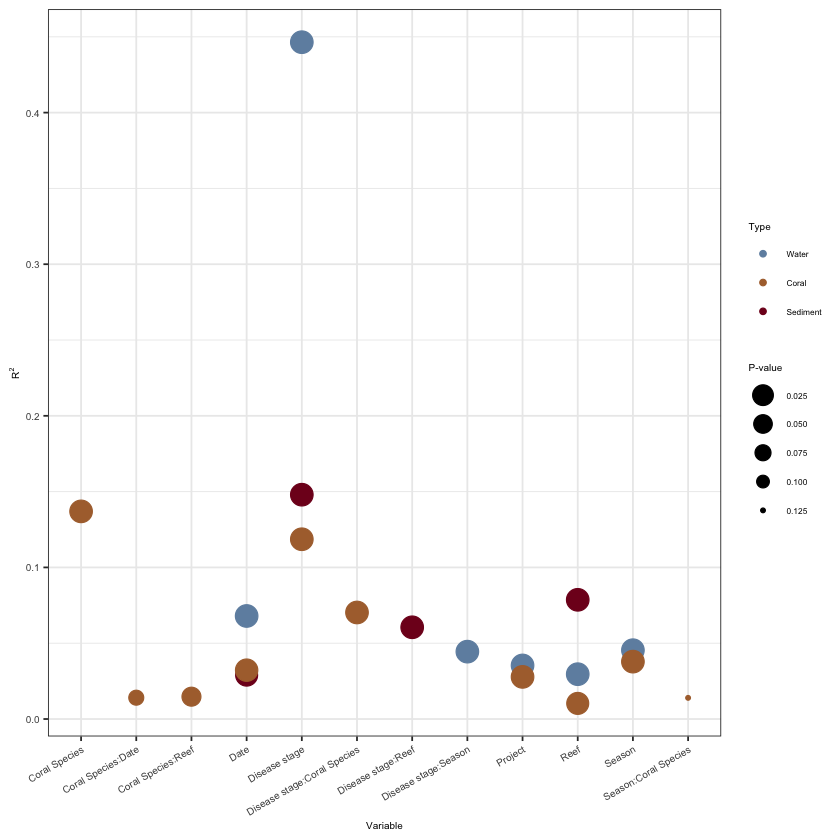

In [32]:
# Convert Type to a factor with specified levels
data_combined$Type <- factor(data_combined$Type, levels = c("Water", "Coral", "Sediment"))

# Create the plot with improved size contrast
data_combined %>%
  ggplot(aes(x = Variable, y = R2, size = Pvalue, color = Type)) +
  geom_point() +
  ylab(expression(R^2)) +
  theme_bw() +
  scale_color_manual("Type", values = c("#6F8FAF", "#AD6F3B", "#800020")) +
  scale_size_continuous(name = "P-value", trans = "reverse", range = c(1, 6)) +  # Increased range for better differentiation
  theme(
    axis.text.x = element_text(angle = 30, hjust = 1, size = 6),
    axis.text.y = element_text(size = 6),
    axis.title.x = element_text(size = 6),
    axis.title.y = element_text(size = 6),
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 6)
  )

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Supp_Fig1.png",
    width = 4, height = 4, units = "in", dpi=300)


In [33]:
R.version

               _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          4                           
minor          4.1                         
year           2024                        
month          06                          
day            14                          
svn rev        86737                       
language       R                           
version.string R version 4.4.1 (2024-06-14)
nickname       Race for Your Life          